### imports

In [1]:
import random
import os
import csv
import tqdm

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from collections import defaultdict

import clip
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split

import kagglehub

In [2]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

### load data

In [3]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)
nltk.download('punkt_tab')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Preprocess

### prepare data

In [4]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # specials tokens
        self.add_word('<pad>')
        self.add_word('<unk>')
        self.add_word('<start>')
        self.add_word('<end>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(t, self.word2idx['<unk>']) for t in tokens]

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, cache_dir):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.cache_dir = cache_dir
        
    def __len__(self): return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, caption = self.data_pairs[idx]
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(self.cache_dir, filename)
        
        try:
            cached = torch.load(load_path)
            feat = cached['features'] if isinstance(cached, dict) else cached
            if len(feat.shape) > 1: feat = feat[0]
        except FileNotFoundError:
            feat = torch.zeros(512) # fallback

        tokens = self.vocab.encode(caption)
        caption_indices = [self.vocab.word2idx['<start>']] + tokens + [self.vocab.word2idx['<end>']]
        return feat, torch.tensor(caption_indices, dtype=torch.long)

In [6]:
class DataManager:
    def __init__(self, dataset_path, img_folder_name="flickr30k_images", captions_filename="captions.txt", cache_dir="cached_features"):
        self.root = dataset_path
        self.img_folder = os.path.join(self.root, img_folder_name)
        self.captions_file = self._find_file(captions_filename)
        self.token_file = os.path.join(self.root, "flickr30k.token.txt")
        self.cache_dir = cache_dir
        self.vocab = Vocab()
        self.data_pairs = []
        
    def _find_file(self, name):
        for root, _, files in os.walk(self.root):
            if name in files: return os.path.join(root, name)
        return None

    def prepare_data(self, limit=None, vocab_max_size=None):
        """Pipeline complet : CSV -> Token -> Vocab -> Pairs"""
        if not os.path.exists(self.token_file):
            self._convert_csv_to_token()
            
        with open(self.token_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        random.seed(42)
        random.shuffle(lines)
        
        count = 0
        for line in lines:
            if limit and count >= limit: break
            
            parts = line.strip().split('\t')
            if len(parts) < 2: continue
            
            img_id = parts[0].split('#')[0]
            caption = parts[1]
            img_path = os.path.join(self.img_folder, img_id)
            
            if os.path.exists(img_path):
                self.data_pairs.append((img_path, caption))
                for w in nltk.tokenize.word_tokenize(caption.lower()):
                    if vocab_max_size and len(self.vocab) >= vocab_max_size: continue
                    self.vocab.add_word(w)
                count += 1
                
        print(f"{Colour.GREEN}✅ Data loaded:{Colour.END} {Colour.BOLD}{len(self.data_pairs)}{Colour.END} pairs | {Colour.BOLD}{len(self.vocab)}{Colour.END} vocab words")

    def _convert_csv_to_token(self):
        try:
            with open(self.captions_file, 'r', encoding='utf-8') as infile, \
                 open(self.token_file, 'w', encoding='utf-8') as outfile:
                reader = csv.reader(infile)
                next(reader)
                for row in reader:
                    if len(row) == 3:
                        outfile.write(f"{row[0]}#{row[1]}\t{row[2]}\n")
        except Exception as e:
            print(f"{Colour.RED}❌ Conversion error:{Colour.END} {e}")
    
    def caption_collate_fn(self, batch):
        imgs, caps = zip(*batch)
        imgs = torch.stack(imgs)
        caps_padded = pad_sequence(caps, batch_first=True, padding_value=0)
        return imgs, caps_padded

    def get_loaders(self, batch_size=64, test_size=0.2):
        """Divise par IMAGE et renvoie les DataLoaders"""
        img_to_caps = {}
        for img, cap in self.data_pairs:
            if img not in img_to_caps: img_to_caps[img] = []
            img_to_caps[img].append(cap)
            
        unique_imgs = list(img_to_caps.keys())
        train_imgs, test_imgs = train_test_split(unique_imgs, test_size=test_size, random_state=42)
        
        train_pairs = [(img, cap) for img in train_imgs for cap in img_to_caps[img]]
        test_pairs = [(img, cap) for img in test_imgs for cap in img_to_caps[img]]
        
        print(f"{Colour.CYAN}📊 Split:{Colour.END} Train {Colour.BOLD}{len(train_pairs)}{Colour.END} | Test {Colour.BOLD}{len(test_pairs)}{Colour.END}")
        
        train_ds = CaptionDataset(train_pairs, self.vocab, self.cache_dir)
        test_ds = CaptionDataset(test_pairs, self.vocab, self.cache_dir)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=self.caption_collate_fn, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=self.caption_collate_fn, drop_last=True)
        
        return train_loader, test_loader, train_pairs, test_pairs


In [7]:
data_manager = DataManager(path)
data_manager.prepare_data(limit=26000, vocab_max_size=5000)
train_loader, test_loader, train_pairs, test_pairs = data_manager.get_loaders(batch_size=100)
vocab = data_manager.vocab

✅ Data loaded: 26000 pairs | 5000 vocab words
📊 Split: Train 20855 | Test 5145


# Part 1 : Alignment

### alignment computation

In [8]:
def get_alignment(img_path, detector, model_align, preprocess_align, device, threshold=0.5):
    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    img_tensor = T.ToTensor()(img_pil).to(device)
    
    with torch.no_grad():
        pred = detector([img_tensor])[0]
        
    keep_score = pred['scores'] > threshold
    boxes = pred['boxes'][keep_score]
    scores = pred['scores'][keep_score]
    
    keep_nms = torchvision.ops.nms(boxes, scores, 0.3)
    final_boxes = boxes[keep_nms][:19]
    crops_tensors = [preprocess_align(img_pil)]

    for box in final_boxes:
        x1, y1, x2, y2 = box.int().tolist()
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_img, x2), min(h_img, y2)
        if x2 - x1 < 1 or y2 - y1 < 1:
            continue
        crop = img_pil.crop((x1, y1, x2, y2))
        crops_tensors.append(preprocess_align(crop))

    batch_input = torch.stack(crops_tensors).to(device)

    with torch.no_grad():
        batch_features = model_align.encode_image(batch_input)
    
    regions_features = [feat.cpu().float().numpy().flatten() for feat in batch_features]
    return regions_features, final_boxes

In [9]:
class RegionDataGenerator:
    def __init__(self, data_pairs, vocab, detector, model_align, preprocess_align, device):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.detector = detector
        self.model_align = model_align
        self.preprocess = preprocess_align
        self.device = device
        
    def generate_region_dataset(self, limit=100):
        region_training_data = []
        
        print(f"{Colour.CYAN}🚀 Generating region data from alignment...{Colour.END}")
        subset = self.data_pairs[:limit] 
        
        for img_path, caption in tqdm.tqdm(subset):
            try:
                region_feats, boxes = get_alignment(img_path, self.detector, self.model_align, self.preprocess, self.device)
                
                if len(region_feats) == 0: continue

                words = nltk.word_tokenize(caption.lower())
                stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
                meaningful_words = [w for w in words if w not in stop_words and w in self.vocab.word2idx]
                
                if not meaningful_words: continue
                img_features_tensor = torch.tensor(np.array(region_feats)).to(self.device)
                img_features_tensor /= img_features_tensor.norm(dim=-1, keepdim=True)

                text_tokens = clip.tokenize(meaningful_words).to(self.device)
                with torch.no_grad():
                    text_features = self.model_align.encode_text(text_tokens)
                    text_features /= text_features.norm(dim=-1, keepdim=True)

                similarity = (100.0 * img_features_tensor @ text_features.T).softmax(dim=0)
                best_region_indices = similarity.argmax(dim=0).cpu().numpy()
                
                for i, word in enumerate(meaningful_words):
                    region_idx = best_region_indices[i]
                    best_feat = region_feats[region_idx]
                    word_idx = self.vocab.word2idx[word]
                    region_training_data.append((best_feat, word_idx))
                    
            except Exception as e:
                continue
                
        print(f"{Colour.GREEN}✅ Generated {len(region_training_data)} region-word pairs.{Colour.END}")
        return region_training_data

In [10]:
class RegionDataset(Dataset):
    def __init__(self, region_data):
        self.data = region_data
        
    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        feat, word_idx = self.data[idx]
        feat_tensor = torch.tensor(feat, dtype=torch.float)
        caption_indices = [vocab.word2idx['<start>'], word_idx, vocab.word2idx['<end>']]
        return feat_tensor, torch.tensor(caption_indices, dtype=torch.long)

### visualization

In [11]:
def visualize_alignment(img_path, caption, detector, model_align, preprocess_align, device, threshold=0.5, dist_test=20):
    region_feats, boxes = get_alignment(img_path, detector, model_align, preprocess_align, device, threshold)
    
    if not boxes.shape[0]:
        print(f"{Colour.RED}no objects detected in image.{Colour.END}")
        return

    img_features = torch.tensor(np.array(region_feats)).to(device)
    img_features /= img_features.norm(dim=-1, keepdim=True)

    words = nltk.word_tokenize(caption.lower())
    stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
    meaningful_words = [w for w in words if w not in stop_words]
    
    if not meaningful_words:
        print(f"{Colour.YELLOW}no meaningful words found after filtering.{Colour.END}")
        return

    with torch.no_grad():
        text_tokens = clip.tokenize(meaningful_words).to(device)
        text_features = model_align.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * img_features @ text_features.T).softmax(dim=0).cpu().numpy()
    best_indices = similarity.argmax(axis=0)
    best_scores = similarity.max(axis=0)

    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    ax.imshow(img_pil)
    
    colors = cm.tab20(range(len(meaningful_words)))
    text_x_start = w_img + (w_img * 0.05)

    for i, (word, best_idx, score) in enumerate(zip(meaningful_words, best_indices, best_scores)):
        color = colors[i]
        
        if best_idx == 0:
            target_x, target_y = w_img / 2, h_img / 2
        else:
            box_idx = best_idx - 1 
            box = boxes[box_idx].cpu().numpy() if isinstance(boxes[box_idx], torch.Tensor) else boxes[box_idx]
            x1, y1, x2, y2 = box
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2.5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            target_x, target_y = (x1 + x2) / 2, (y1 + y2) / 2
        text_y = (i * dist_test) + (h_img * 0.05)
        label_text = f"{word} ({score:.2f})"
        ax.text(text_x_start, text_y, label_text, 
                fontsize=13, fontweight='bold', color='black', 
                va='center', ha='left', family='monospace',
                bbox=dict(boxstyle='square,pad=0.4', facecolor=color, edgecolor='none', alpha=0.9))

        if score > 0.1: # threshold to draw arrow
            ax.annotate('', 
                        xy=(target_x, target_y), 
                        xytext=(text_x_start, text_y),
                        arrowprops=dict(arrowstyle='->', color=color, linewidth=2, mutation_scale=15))

    ax.set_xlim(0, w_img * 1.6) 
    ax.set_ylim(h_img, 0) # flip Y to match image coordinates
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

### rcnn model & CLIP

In [12]:
model_align, preprocess_align = clip.load("ViT-B/32", device=DEVICE)
model_align.eval()

weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(DEVICE)   # pretrained=True
resnet.eval()

print(f"{Colour.GREEN}✅ Models loaded{Colour.END}")
print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Models loaded
💻 Device: CPU


# Captioning

### captioning model

In [13]:
class CaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, image_feature_dim, hidden_size, dropout_prob=0.5):
        super().__init__()
        self.image_feature_dim = image_feature_dim
        self.image_projection = nn.Linear(image_feature_dim, embed_dim)
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim + embed_dim, hidden_size=hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, image_features, captions):
        img_emb = self.image_projection(image_features) # [Batch, Embed_Dim]
        img_emb = F.relu(img_emb)
        
        word_embeds = self.word_embedding(captions)     # [Batch, Seq_Len, Embed_Dim]
        word_embeds = self.dropout(word_embeds)
        
        seq_len = word_embeds.size(1)
        img_emb_expanded = img_emb.unsqueeze(1).expand(-1, seq_len, -1)
        
        lstm_inputs = torch.cat((word_embeds, img_emb_expanded), dim=2) 
        lstm_out, _ = self.lstm(lstm_inputs)
        
        return self.output_projection(lstm_out)

    def sample(self, image_features, vocab, max_len=20, temperature=1.0, device='cpu'):
        self.eval()
        with torch.no_grad():
            img_emb = self.image_projection(image_features)
            img_emb = F.relu(img_emb)
            img_emb = img_emb.unsqueeze(1) 
            
            hidden = None 
            start_token = vocab.word2idx.get('<start>', vocab.word2idx.get('<unk>', 1))
            current_input_idx = torch.tensor([start_token]).long().to(device).unsqueeze(0) # [1, 1]
            
            generated_ids = []
            
            for i in range(max_len):
                word_emb = self.word_embedding(current_input_idx) # [1, 1, Embed_Dim]

                lstm_input = torch.cat((word_emb, img_emb), dim=2) # [1, 1, Embed_Dim * 2]
                lstm_out, hidden = self.lstm(lstm_input, hidden)
                outputs = self.output_projection(lstm_out) # [1, 1, Vocab]
                
                probs = F.softmax(outputs[0, 0] / temperature, dim=0)
                
                if temperature == 0:
                    next_word_idx = torch.argmax(probs).item()
                else:
                    next_word_idx = torch.multinomial(probs, 1).item()
                
                if next_word_idx == vocab.word2idx.get('<end>', 0):
                    break
                
                generated_ids.append(next_word_idx)
                current_input_idx = torch.tensor([next_word_idx]).long().to(device).unsqueeze(0)
                
            tokens = [vocab.idx2word.get(idx, '<unk>') for idx in generated_ids]
            return " ".join(tokens)

### train one epoch

In [14]:
def train_one_captioning_epoch(dataloader, model_captioning, optimizer, criterion, device, clip_threshold=5.0):
    model_captioning.train()
    total_loss = 0
    count = 0
    
    pbar = tqdm.tqdm(dataloader, desc="Training Captioning")
    
    for batch in pbar:
        img_feats, captions = batch
        img_feats = img_feats.to(device)
        captions = captions.to(device)
        
        targets = captions[:, 1:] # Tout sauf le premier (<start>)
        inputs = captions[:, :-1] # Tout sauf le dernier (<end> ou padding)
        
        optimizer.zero_grad()
        
        outputs = model_captioning(img_feats, inputs) # [Batch, Seq_Len-1, Vocab]
        
        outputs_flat = outputs.reshape(-1, outputs.shape[-1])
        targets_flat = targets.reshape(-1)
        
        loss = criterion(outputs_flat, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_captioning.parameters(), clip_threshold)
        
        optimizer.step()
        
        total_loss += loss.item()
        count += 1
        pbar.set_description(f"Loss: {loss.item():.4f}")
        
    return total_loss / count

In [15]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 512
IMG_FEAT_DIM = 512
HIDDEN_SIZE = 512

### To ease the demo, we will not do the first part of training here.

### precompute features and save them

In [16]:
# def cache_region_data(data_pairs, vocab, detector, model_align, preprocess_align, device, save_path="cached_features/region_dataset_cache.pt", limit=None):
#     if os.path.exists(save_path):
#         print(f"{Colour.GREEN}✅ Region dataset found at {Colour.BOLD}{save_path}{Colour.END}")
#         return torch.load(save_path, weights_only=False)

#     print(f"{Colour.CYAN}🚀 Generating and caching region data (This happens only once)...{Colour.END}")
#     region_training_data = []
    
#     subset = data_pairs[:limit] if limit else data_pairs
#     pbar = tqdm.tqdm(subset)
    
#     for img_path, caption in pbar:
#         try:
#             region_feats, boxes = get_alignment(img_path, detector, model_align, preprocess_align, device)
            
#             if len(region_feats) == 0: continue

#             words = nltk.word_tokenize(caption.lower())
#             stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
#             meaningful_words = [w for w in words if w not in stop_words and w in vocab.word2idx]
            
#             if not meaningful_words: continue

#             text_tokens = clip.tokenize(meaningful_words).to(device)
#             with torch.no_grad():
#                 text_features = model_align.encode_text(text_tokens)
#                 text_features /= text_features.norm(dim=-1, keepdim=True)
            
#             img_features_tensor = torch.tensor(np.array(region_feats)).to(device).to(text_features.dtype)
#             img_features_tensor /= img_features_tensor.norm(dim=-1, keepdim=True)

#             similarity = (100.0 * img_features_tensor @ text_features.T).softmax(dim=0)
#             best_region_indices = similarity.argmax(dim=0).cpu().numpy()
            
#             for i, word in enumerate(meaningful_words):
#                 region_idx = best_region_indices[i]
#                 best_feat = region_feats[region_idx] 
#                 word_idx = vocab.word2idx[word]
#                 region_training_data.append((best_feat, word_idx))
                
#         except Exception as e:
#             continue
    
#     print(f"{Colour.GREEN}💾 Saving {len(region_training_data)} pairs to {save_path}...{Colour.END}")
#     torch.save(region_training_data, save_path)
#     return region_training_data


In [17]:
# region_data = cache_region_data(train_pairs, vocab, resnet, model_align, preprocess_align, DEVICE, limit=26000)
# region_ds = RegionDataset(region_data)
# region_loader = DataLoader(region_ds, batch_size=100, shuffle=True, collate_fn=data_manager.caption_collate_fn)

### do we have a pretrained model?

In [18]:
pretrained_model_captioning = False

In [19]:
# IMG_FEAT_DIM_REGION = 512

# # that part is done only if we want to train from scratch
# if not pretrained_model_captioning:
#     print(f"{Colour.CYAN}🚀 STEP 1: Setting up Region Model (CLIP features)...{Colour.END}")
#     model_captioning_region = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM_REGION, HIDDEN_SIZE).to(DEVICE)
#     optimizer_captioning_region = torch.optim.RMSprop(model_captioning_region.parameters(), lr=1e-4)
#     train_losses_region = []
#     epoch_region = 0
#     criterion_captioning_region = nn.CrossEntropyLoss(ignore_index=vocab.word2idx.get('<pad>', 0))
#     print(f"{Colour.GREEN}✅ REGION Model initialized (Input: 512){Colour.END}")

In [20]:
# # that part is done only if we want to train from scratch
# if not pretrained_model_captioning:
#     print(f"{Colour.CYAN}🚀 Starting Region Training on {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

#     epoch_max_region = 1
#     # epoch_max_region = 20

#     while epoch_region < epoch_max_region:
#         print(f"\n{Colour.BOLD}=== Region Epoch {epoch_region+1}/{epoch_max_region} ==={Colour.END}")
        
#         avg_loss_region = train_one_captioning_epoch(region_loader, model_captioning_region, optimizer_captioning_region, criterion_captioning_region, device=DEVICE, clip_threshold=5.0)
#         train_losses_region.append(avg_loss_region)
        
#         print(f"{Colour.GREEN}📉 Avg Region Loss: {Colour.BOLD}{avg_loss_region:.4f}{Colour.END}")
#         epoch_region += 1

#     print(f"\n{Colour.GREEN}✅ Region Training complete! The LSTM now knows the vocabulary.{Colour.END}")

In [21]:
if pretrained_model_captioning:
    file_saved_model = 'saved_models/captioning_model_epoch_60.pth'
    checkpoint = torch.load(file_saved_model, map_location=DEVICE)
    model_captioning = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM, HIDDEN_SIZE).to(DEVICE)
    model_captioning.load_state_dict(checkpoint['model_state_dict'])
    optimizer_captioning = torch.optim.RMSprop(model_captioning.parameters(), lr=1e-4)
    optimizer_captioning.load_state_dict(checkpoint['optimizer_state_dict'])
    vocab.word2idx = checkpoint['vocab_word2idx']
    vocab.idx2word = checkpoint['vocab_idx2word']
    train_losses = checkpoint['train_losses']
    epoch = checkpoint['epoch']
    print(f"{Colour.GREEN}✅ Pretrained model loaded.{Colour.END}")
else:
    model_captioning = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM, HIDDEN_SIZE).to(DEVICE)

    # # greffe
    # region_state = model_captioning_region.state_dict()
    # full_state = model_captioning.state_dict()
    # region_state = model_captioning_region.state_dict()
    # full_state = model_captioning.state_dict()

    # pretrained_dict = {k: v for k, v in region_state.items() if k in full_state and 'image_projection' not in k}

    # full_state.update(pretrained_dict)
    # model_captioning.load_state_dict(full_state)

    print(f"{Colour.GREEN}✅ Transfer complete! Model is ready for full sentences.{Colour.END}")

    optimizer_captioning = torch.optim.RMSprop(model_captioning.parameters(), lr=1e-4)
    train_losses = []
    epoch = 0
    print(f"{Colour.GREEN}✅ REGION Model initialized (Input: 512){Colour.END}")

criterion_captioning = nn.CrossEntropyLoss(ignore_index=vocab.word2idx.get('<pad>', 0))

✅ Transfer complete! Model is ready for full sentences.
✅ REGION Model initialized (Input: 512)


In [22]:
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

epoch_max = 3
# epoch_max = 100

print(f"{Colour.CYAN}🚀 Starting Full-Image Training on {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

while epoch < epoch_max:
    print(f"\n{Colour.BOLD}=== Full Epoch {epoch+1}/{epoch_max} ==={Colour.END}")
    avg_loss = train_one_captioning_epoch(train_loader, model_captioning, optimizer_captioning, criterion_captioning, device=DEVICE, clip_threshold=5.0)    
    train_losses.append(avg_loss)
    
    if len(train_losses) <= 1:
        print(f"{Colour.GREEN}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END}")
    elif train_losses[-2] > train_losses[-1]:
        print(f"{Colour.GREEN}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END}")
    else:
        print(f"{Colour.RED}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END} (did not improve)")
    
    if epoch % 10 == 0:
        torch.save({
        'model_state_dict': model_captioning.state_dict(),
        'optimizer_state_dict': optimizer_captioning.state_dict(),
        'vocab_word2idx': vocab.word2idx,
        'vocab_idx2word': vocab.idx2word,
        'train_losses': train_losses,
        'epoch': epoch
    }, f'saved_models/captioning_model_epoch_{epoch}.pth')
        
    epoch += 1

print(f"\n{Colour.GREEN}✅ All training complete! You can now visualize.{Colour.END}")

🚀 Starting Full-Image Training on CPU

=== Full Epoch 1/3 ===


Loss: 4.3300: 100%|██████████| 208/208 [00:37<00:00,  5.59it/s]


📉 Avg Loss: 4.7792

=== Full Epoch 2/3 ===


Loss: 4.0669: 100%|██████████| 208/208 [00:38<00:00,  5.37it/s]


📉 Avg Loss: 4.2147

=== Full Epoch 3/3 ===


Loss: 3.9844: 100%|██████████| 208/208 [00:40<00:00,  5.18it/s]

📉 Avg Loss: 4.0232

✅ All training complete! You can now visualize.


In [23]:
def plot_training_loss(train_losses):
    if not train_losses:
        print(f"{Colour.YELLOW}[WARNING] No training loss data to plot.{Colour.END}")
        return

    epochs = range(1, len(train_losses) + 1)

    fig, ax = plt.subplots(figsize=(10, 6), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)
    line_color = "#0b9220"
    ax.plot(epochs, train_losses, marker='o', 
            linewidth=2, 
            markersize=6, 
            color=line_color, 
            markerfacecolor=line_color,
            label='Train Loss')

    ax.fill_between(epochs, train_losses, alpha=0.3, color=line_color)
    plt.xlabel('Epoch', fontsize=12, color=text_color, family='monospace')
    plt.ylabel('Loss', fontsize=12, color=text_color, family='monospace')
    plt.title('Training Loss Over Epochs', fontsize=14, color=text_color, pad=15, family='monospace')

    ax.tick_params(axis='both', colors=text_color, labelsize=10, length=6, width=1.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(text_color)
    ax.spines['bottom'].set_linewidth(1.2)

    ax.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.2, color='white')

    if len(train_losses) <= 20:
        ax.set_xticks(epochs)
    else:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_xlim(1, max(epochs) if len(epochs) > 0 else 1)
    ax.set_ylim(0, None)
        
    plt.tight_layout()

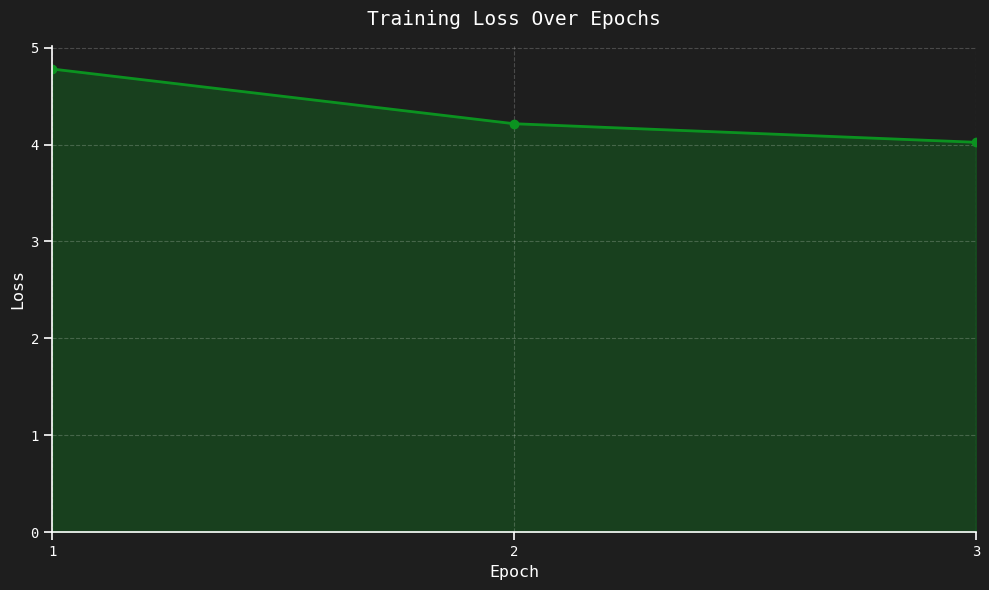

In [24]:
plot_training_loss(train_losses)